In [ ]:
import kagglehub

# Download
path = kagglehub.dataset_download("awsaf49/cbis-ddsm-breast-cancer-image-dataset")

print("Dataset baixado em:", path)

#https://www.kaggle.com/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset/data

Using Colab cache for faster access to the 'cbis-ddsm-breast-cancer-image-dataset' dataset.
Dataset baixado em: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset


**Parte 1**

Verifica o caminho da pasta

In [1]:
from google.colab import drive
import os

# Monta o Google Drive na máquina virtual do Colab
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/Unifesp/Projeto_Cancer/archive.zip'

if os.path.exists(zip_path):
    print("Arquivo zip encontrado com sucesso!")
else:
    print(f"ERRO: Não encontrei o arquivo em {zip_path}. Verifique o nome da pasta/arquivo no Drive.")

Mounted at /content/drive
Arquivo zip encontrado com sucesso!


**Parte 1.1**

Encontra as imagens e combina com as informações (rótulos) do arquivo de metadados (CSV) para que o programa possa aprender com elas.


In [ ]:
import os
import zipfile
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# --- 1. CONFIGURAÇÃO E EXTRAÇÃO ---
# Caminho da imagem
ZIP_PATH = '/content/drive/MyDrive/Unifesp/Projeto_Cancer/archive.zip'
EXTRACT_PATH = '/content/dados_extraidos'

if not os.path.exists(EXTRACT_PATH):
    print(f"Descompactando {ZIP_PATH}...")
    try:
        with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
            zip_ref.extractall(EXTRACT_PATH)
        print("Descompactação concluída.")
    except Exception as e:
        print(f"Erro ao descompactar: {e}")
        exit() # Para se der erro
else:
    print("Arquivos já descompactados anteriormente.")

# --- 2. MAPEAMENTO E PREPARAÇÃO DO DATASET (MODO POR PASTA/UID) ---
print("Localizando e processando metadados (CSVs)...")

csv_train = glob.glob(os.path.join(EXTRACT_PATH, "**", "mass_case_description_train_set.csv"), recursive=True)
csv_test = glob.glob(os.path.join(EXTRACT_PATH, "**", "mass_case_description_test_set.csv"), recursive=True)

if not csv_train:
    raise FileNotFoundError("CSV de treino não encontrado.")

df = pd.read_csv(csv_train[0])
if csv_test:
    df_test = pd.read_csv(csv_test[0])
    df = pd.concat([df, df_test], ignore_index=True)

# Mapeamento de Classes
def get_article_label(pathology):
    if 'MALIGNANT' in pathology: return 'Malignant'
    if 'BENIGN_WITHOUT_CALLBACK' in pathology: return 'Normal'
    if 'BENIGN' in pathology: return 'Benign'
    return None

df['label'] = df['pathology'].apply(get_article_label)
df = df.dropna(subset=['label'])

# --- INDEXA POR NOME DA PASTA (UID) ---
print("Indexando imagens pelo ID da pasta...")
folder_map = {}

# Varre todas as pastas e guarda onde estão as imagens JPG
for root, dirs, files in os.walk(EXTRACT_PATH):
    # Filtra apenas arquivos de imagem
    images_in_folder = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if images_in_folder:
        # O nome da pasta atual (aquele numero 1.3.6.1.4...) será a chave
        folder_name = os.path.basename(root)

        # Guarda o caminho completo das imagens dessa pasta
        full_paths = [os.path.join(root, img) for img in images_in_folder]
        folder_map[folder_name] = full_paths

print(f"Total de pastas com imagens encontradas: {len(folder_map)}")

# Cruzamento CSV <-> Imagem
valid_data = []
print("Cruzando dados (Buscando ID da pasta do CSV no disco)...")

for idx, row in df.iterrows():
    # Preferência: Imagem Recortada (ROI) > Imagem Completa
    # O CSV tem caminhos tipo: "Mass-Training_.../1.3.6.1.4.1...UID.../000000.dcm"
    paths_to_try = [row.get('cropped image file path'), row.get('image file path')]

    found_filepath = None

    for csv_path in paths_to_try:
        if pd.isna(csv_path): continue

        # Quebra o caminho do CSV em partes (separado por /)
        # Ex: ['Mass-Training...', '1.3.6.1.4.1.9590...', '1.3.6.1.4.1.9590...', '000000.dcm']
        path_parts = csv_path.split('/')

        # Verifica se alguma parte desse caminho corresponde a uma pasta que achamos no disco
        for part in path_parts:
            if part in folder_map:
                candidates = folder_map[part]

                # SE TIVER MAIS DE UMA IMAGEM NA PASTA (Caso da sua imagem 3: ROI + Máscara)
                # Pega a maior imagem (geralmente a textura do ROI é maior que a máscara binária)
                if len(candidates) > 1:
                    try:
                        # Pega o arquivo com maior tamanho em bytes (evita pegar a máscara preta)
                        found_filepath = max(candidates, key=os.path.getsize)
                    except:
                        found_filepath = candidates[0]
                else:
                    found_filepath = candidates[0]

                break

        if found_filepath: break

    if found_filepath:
        valid_data.append({'filepath': found_filepath, 'label': row['label']})

df_final = pd.DataFrame(valid_data)

# --- VERIFICAÇÃO FINAL ---
if len(df_final) == 0:
    print("\nERRO CRÍTICO PERSISTE.")
    print("Debug - Chaves encontradas no disco (exemplo):", list(folder_map.keys())[:3])
    print("Debug - Caminho no CSV (exemplo):", df.iloc[0]['image file path'])
    raise ValueError("Não foi possível casar as pastas do CSV com as pastas do disco.")

print(f"SUCESSO! Total de imagens vinculadas: {len(df_final)}")
print("Distribuição:\n", df_final['label'].value_counts())

Descompactando /content/drive/MyDrive/Unifesp/Projeto_Cancer/archive.zip...
Descompactação concluída.
Localizando e processando metadados (CSVs)...
Indexando imagens pelo ID da pasta...
Total de pastas com imagens encontradas: 6774
Cruzando dados (Buscando ID da pasta do CSV no disco)...
SUCESSO! Total de imagens vinculadas: 1696
Distribuição:
 label
Malignant    784
Benign       771
Normal       141
Name: count, dtype: int64


In [ ]:
df_final.head()

,filepath,label
0,/content/dados_extraidos/jpeg/1.3.6.1.4.1.9590...,Malignant
1,/content/dados_extraidos/jpeg/1.3.6.1.4.1.9590...,Malignant
2,/content/dados_extraidos/jpeg/1.3.6.1.4.1.9590...,Benign
3,/content/dados_extraidos/jpeg/1.3.6.1.4.1.9590...,Benign
4,/content/dados_extraidos/jpeg/1.3.6.1.4.1.9590...,Benign


**Parte 2**

Filtro para termos apenas as bases quase balanceadas devida a mesma quantidade entre dados de maligno e benigno

In [ ]:
df_final_binario = df_final[df_final['label'] != 'Normal']

# Reseta o índice
df_final_binario = df_final_binario.reset_index(drop=True)

print(f"Total de imagens restantes: {len(df_final_binario)}")
print("Nova distribuição:\n", df_final_binario['label'].value_counts())

Total de imagens restantes: 1555
Nova distribuição:
 label
Malignant    784
Benign       771
Name: count, dtype: int64


In [ ]:
df_final_binario.head()

,filepath,label
0,/content/dados_extraidos/jpeg/1.3.6.1.4.1.9590...,Malignant
1,/content/dados_extraidos/jpeg/1.3.6.1.4.1.9590...,Malignant
2,/content/dados_extraidos/jpeg/1.3.6.1.4.1.9590...,Benign
3,/content/dados_extraidos/jpeg/1.3.6.1.4.1.9590...,Benign
4,/content/dados_extraidos/jpeg/1.3.6.1.4.1.9590...,Benign


**Imagem Original**

ROI mask images: o desenho do local do tumor

Visualizando 5 imagens aleatórias dos dados de leitura...


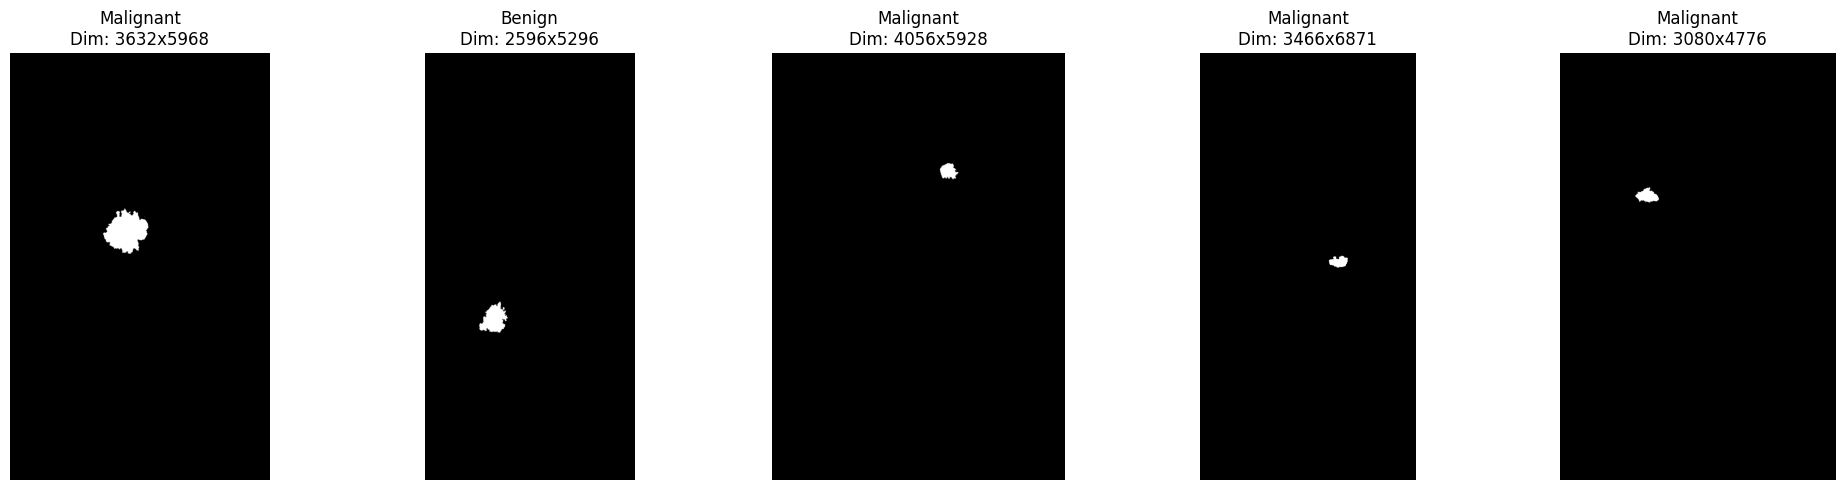

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

def visualizar_amostra_leitura(df, num_samples=5):
    # Seleciona índices aleatórios
    indices = np.random.choice(df.index, num_samples, replace=False)

    plt.figure(figsize=(20, 5))

    for i, idx in enumerate(indices):
        caminho = df.loc[idx, 'filepath']
        rotulo = df.loc[idx, 'label']

        # Leitura da imagem
        img = cv2.imread(caminho)

        if img is not None:
            # OpenCV carrega em BGR (Azul-Verde-Vermelho) e convertemos para RGB para o Matplotlib
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            altura, largura, canais = img.shape

            plt.subplot(1, num_samples, i + 1)
            plt.imshow(img_rgb)
            plt.title(f"{rotulo}\nDim: {largura}x{altura}")
            plt.axis('off')
        else:
            print(f"Erro ao ler a imagem no índice {idx}: {caminho}")

    plt.tight_layout()
    plt.show()

# Chama a função
print("Visualizando 5 imagens aleatórias dos dados de leitura...")
visualizar_amostra_leitura(df_final_binario)




**Contraponto com relação ao Artigo**

Comparação de redes (criar hipótese não é boa, para isso comparar, ou pode ser a base, parametros, aumento)

 ver com outras arquiteturas e aumento da

 # Artigos novos

 https://www.mdpi.com/2075-4418/15/22/2829  (pago para publicar)

 https://pmc.ncbi.nlm.nih.gov/articles/PMC9208612/

 # Artigo a ser estudado será que a rede é ruim? ou é a base que é ruim? (hipótese)

https://www.techscience.com/iasc/v32n2/45574/html

# Ver as estruturas da mama
# Virar um contraponto
# Aumento de dados igual ao artigo
# Pegar os mesmos parametros do artigo e ver com outras redes


# Referencias de outras redes para testar (3.2) Ver arquiteturas que possa comprar e redes do artigo

**Leitura da base**

In [2]:
import os
import zipfile
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2

# --- 1. CONFIGURAÇÃO ---
ZIP_PATH = '/content/drive/MyDrive/Unifesp/Projeto_Cancer/archive.zip'
EXTRACT_PATH = '/content/dados_extraidos'

if not os.path.exists(EXTRACT_PATH):
    print(f"Descompactando {ZIP_PATH}...")
    try:
        with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
            zip_ref.extractall(EXTRACT_PATH)
    except Exception as e:
        print(f"Erro: {e}")
else:
    print("Arquivos prontos.")

# --- 2. CARREGA METADADOS ---
print("Lendo CSVs...")
csv_files = glob.glob(os.path.join(EXTRACT_PATH, "**", "*case_description*.csv"), recursive=True)
df_list = [pd.read_csv(f) for f in csv_files]
df = pd.concat(df_list, ignore_index=True)

# Mapeamento
def get_label(pathology):
    p = str(pathology).upper()
    if 'MALIGNANT' in p: return 'Malignant'
    if 'BENIGN' in p: return 'Benign'
    return 'Normal'

df['label'] = df['pathology'].apply(get_label)
df = df[df['label'] != 'Normal']
print(f"Total de casos (Benigno/Maligno): {len(df)}")

# --- 3. INDEXAÇÃO DAS PASTAS ---
print("Indexando pastas...")
folder_map = {}
for root, dirs, files in os.walk(EXTRACT_PATH):
    images = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if images:
        folder_name = os.path.basename(root)
        full_paths = [os.path.join(root, img) for img in images]
        folder_map[folder_name] = full_paths

# --- 4. CRUZAMENTO COM LÓGICA DE CONTEÚDO ---
print("Vinculando imagens baseada na Textura...")
valid_data = []

for idx, row in df.iterrows():
    # Prioridade no CSV: Cropped > ROI Mask > Image
    paths = [row.get('cropped image file path'), row.get('ROI mask file path'), row.get('image file path')]
    found_path = None

    for csv_path in paths:
        if pd.isna(csv_path): continue
        parts = str(csv_path).split('/')

        for part in parts:
            if part in folder_map:
                candidates = folder_map[part]

                # --- ESCOLHE PELA COMPLEXIDADE DA IMAGEM ---
                if len(candidates) > 1:
                    best_candidate = None
                    max_unique_colors = -1

                    for cand in candidates:
                        try:
                            # Lê a imagem em escala de cinza apenas para verificar
                            img_check = cv2.imread(cand, cv2.IMREAD_GRAYSCALE)
                            if img_check is None: continue

                            # Conta quantos tons de cinza únicos existem
                            # Máscara terá ~2 (0 e 255). Tecido terá > 50.
                            unique_colors = len(np.unique(img_check))

                            if unique_colors > max_unique_colors:
                                max_unique_colors = unique_colors
                                best_candidate = cand
                        except:
                            continue

                    found_path = best_candidate
                else:
                    found_path = candidates[0]

                break
        if found_path: break

    if found_path:
        valid_data.append({'filepath': found_path, 'label': row['label']})

df_final = pd.DataFrame(valid_data)
df_final = df_final.reset_index(drop=True)

print(f"\nSUCESSO! Imagens vinculadas: {len(df_final)}")

Descompactando /content/drive/MyDrive/Unifesp/Projeto_Cancer/archive.zip...
Lendo CSVs...
Total de casos (Benigno/Maligno): 3568
Indexando pastas...
Vinculando imagens baseada na Textura...

SUCESSO! Imagens vinculadas: 3568


In [3]:
# --- CONTAGEM E ESTATÍSTICAS ---
contagem = df_final['label'].value_counts()
total = len(df_final)

print("-" * 30)
print("DISTRIBUIÇÃO DAS CLASSES")
print("-" * 30)
for classe, qtd in contagem.items():
    porcentagem = (qtd / total) * 100
    print(f"{classe}: {qtd} imagens ({porcentagem:.2f}%)")
print("-" * 30)

------------------------------
DISTRIBUIÇÃO DAS CLASSES
------------------------------
Benign: 2111 imagens (59.16%)
Malignant: 1457 imagens (40.84%)
------------------------------



Imagem e os Tamanhos...


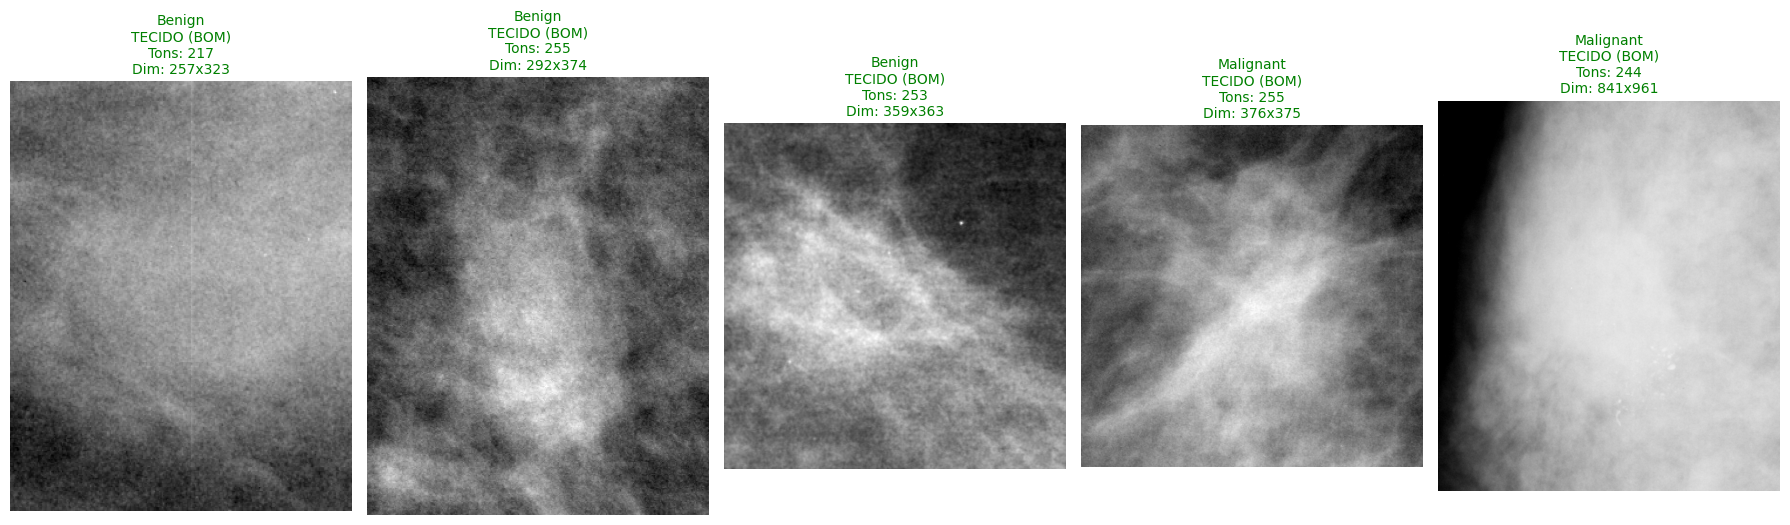

In [ ]:
# --- 5. PROVA REAL (VISUALIZAÇÃO COM DIMENSÕES) ---
def check_images(df):
    # Seleciona 5 índices aleatórios
    indices = np.random.choice(df.index, 5, replace=False)

    plt.figure(figsize=(18, 6)) # Aumentei um pouco a largura para caber os textos

    for i, idx in enumerate(indices):
        path = df.loc[idx, 'filepath']
        label = df.loc[idx, 'label']

        # Lê a imagem
        img = cv2.imread(path)

        plt.subplot(1, 5, i+1)

        if img is not None:
            # --- NOVO: PEGAR DIMENSÕES ---
            # shape retorna (Altura, Largura, Canais)
            altura, largura, _ = img.shape

            # Conta tons de cinza (Complexidade da textura)
            tons = len(np.unique(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)))

            # Converte para RGB para plotar corretamente
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            plt.imshow(img)

            # Lógica de validação visual
            tipo = "MÁSCARA (RUIM)" if tons < 20 else "TECIDO (BOM)"
            cor_texto = 'red' if tons < 20 else 'green' # Texto verde se for tecido, vermelho se for máscara

            # Título com todas as informações
            plt.title(f"{label}\n{tipo}\nTons: {tons}\nDim: {largura}x{altura}",
                      fontsize=10, color=cor_texto)
            plt.axis('off')
        else:
            plt.text(0.5, 0.5, "Erro leitura", ha='center')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

print("\nImagem e os Tamanhos...")
check_images(df_final)

Fase 1: Preparação e Pré-processamento das Imagens

O artigo descreve uma sequência rígida de tratamento de imagem para limpar ruídos e realçar características do tumor.

Metodologia do Artigo (Seção 3):

    Remoção de Fundo (Background Removal): Eliminar artefatos pretos desnecessários.

    Filtro Wiener: Para remoção de ruído (suavização).

    CLAHE (Contrast Limited Adaptive Histogram Equalization): Para realçar o contraste local das massas/calcificações.

    Decomposição Wavelet (WPD - Wavelet Packet Decomposition): Utilizando a wavelet Daubechies (db3) no nível 3 para extrair características suavizadas.

In [4]:
import cv2
import numpy as np
import pywt
import matplotlib.pyplot as plt

def preprocess_image_paper_method(image_path):
    # 1. Carregar imagem (Escala de cinza)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None: return None

    # Redimensionar para o input do GoogleNet (224x224) - Padrão necessário
    img_resized = cv2.resize(img, (224, 224))

    # 2. Remoção de Fundo e Ruído (Wiener Filter)
    # O artigo cita janela 3x3 para o filtro Wiener
    # A implementação exata do Wiener requer scipy.signal.wiener
    from scipy.signal import wiener
    img_wiener = wiener(img_resized, (3, 3)) # Janela 3x3
    img_wiener = img_wiener.astype(np.uint8)

    # 3. Realce de Contraste (CLAHE)
    # Artigo cita Clip Limit 0.01 ou 0.02. No OpenCV 2.0 é padrão, ajustamos para ser suave.
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_clahe = clahe.apply(img_wiener)

    # 4. Wavelet Packet Decomposition (db3, nível 3)
    # O artigo usa isso para suavidade. Se pega a aproximação (Low-Low frequency)
    coeffs = pywt.wavedec2(img_clahe, 'db3', level=3)
    cA3 = coeffs[0] # Coeficiente de aproximação do nível 3

    # Redimensionar o resultado da Wavelet de volta para 224x224 para entrar na CNN
    # Pois a wavelet reduz a dimensão da imagem
    img_final = cv2.resize(cA3, (224, 224))

    # Normalizar para 0-1 ou manter formato de imagem dependendo do loader
    img_final_norm = cv2.normalize(img_final, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Converter para 3 canais (GoogleNet exige entrada RGB, mesmo sendo cinza)
    img_final_rgb = cv2.cvtColor(img_final_norm, cv2.COLOR_GRAY2RGB)

    return img_resized, img_clahe, img_final_rgb

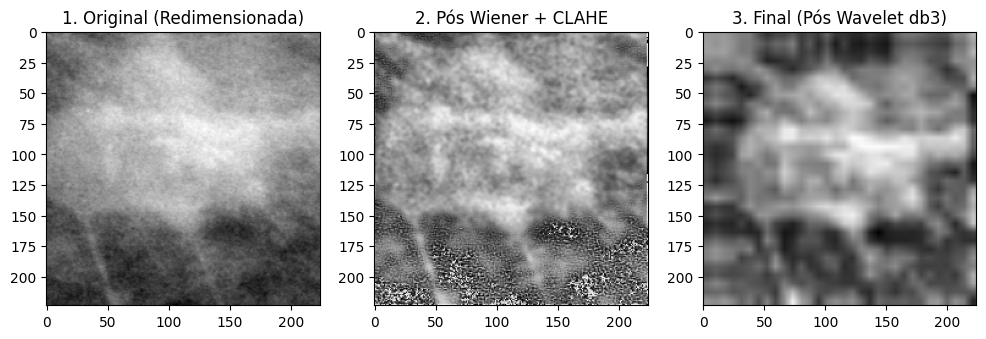

In [ ]:
# --- VISUALIZAÇÃO  ---
path = df_final['filepath'].iloc[1] # Pega o caminho da primeira imagem do DataFrame
original, pos_clahe, final = preprocess_image_paper_method(path)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("1. Original (Redimensionada)")
plt.imshow(original, cmap='gray')

plt.subplot(1, 3, 2)
plt.title("2. Pós Wiener + CLAHE")
plt.imshow(pos_clahe, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("3. Final (Pós Wavelet db3)")
plt.imshow(final) # Mostrando como RGB
plt.show()

Fase 2: Arquitetura da Rede Neural (GoogleNet)

O artigo utiliza a GoogleNet (também conhecida como Inception V1). O diferencial dessa rede são os módulos Inception, que aplicam convoluções de diferentes tamanhos (1×1, 3×3, 5×5) simultaneamente.

Estrutura conforme o Artigo:

    Entrada: Imagens 224×224×3.

    Camadas Iniciais: Convolução padrão + Max Pooling.

    Módulos Inception: 9 módulos empilhados (inception 3a, 3b, ..., 5b).

    Classificador Final:

        Average Pooling.

        Dropout (40% ou 50% para evitar overfitting).

        Camada Linear (Fully Connected).

        Softmax: Configurada para 2 classes (Benigno vs Maligno) ou conforme labels.

In [5]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# 1. Converter classes para números (Maligno=1, Benigno=0)
# Ajuste conforme os nomes exatos na sua coluna 'label' do df_final
df_final['target'] = df_final['label'].apply(lambda x: 1 if str(x).lower() == 'malignant' else 0)

# 2. Divisão 70% Treino / 30% Teste (Rigorosamente conforme o Artigo)
train_df, test_df = train_test_split(
    df_final,
    test_size=0.30,
    stratify=df_final['target'], # Mantém a proporção de câncer nos dois grupos
    random_state=42
)

print(f"Total Imagens: {len(df_final)}")
print(f"Treino (70%): {len(train_df)}")
print(f"Teste  (30%): {len(test_df)}")

Total Imagens: 3568
Treino (70%): 2497
Teste  (30%): 1071


**O Gerador (Conectando sua função à Rede)**

Este gerador vai ler o caminho da imagem do df_final, aplicar a função preprocess_image_paper_method e entregar apenas a imagem final para a GoogleNet.

In [6]:
from tensorflow.keras.utils import Sequence

class CustomDataGenerator(Sequence):
    def __init__(self, dataframe, x_col, y_col, batch_size=10, shuffle=True):
        self.dataframe = dataframe
        self.x_col = x_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.dataframe))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.floor(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        # Seleciona os índices do lote atual
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_df = self.dataframe.iloc[indexes]

        # Prepara arrays vazios
        X = np.empty((self.batch_size, 224, 224, 3))
        y = np.empty((self.batch_size, 2), dtype=float)

        for i, (_, row) in enumerate(batch_df.iterrows()):
            img_path = row[self.x_col]

            # --- AQUI CHAMAMOS A SUA FUNÇÃO ---
            # Sua função retorna: (original, clahe, final)
            # Pegamos o índice [2] que é a 'img_final_rgb'
            try:
                processed_tuple = preprocess_image_paper_method(img_path)

                if processed_tuple is None:
                    # Se der erro na leitura, gera imagem preta pra não travar
                    img_final = np.zeros((224, 224, 3))
                else:
                    img_final = processed_tuple[2]

                # Normalização para 0-1 (Fundamental para Redes Neurais)
                X[i,] = img_final / 255.0

            except Exception as e:
                print(f"Erro ao processar {img_path}: {e}")
                X[i,] = np.zeros((224, 224, 3))

            # Labels (One-Hot Encoding para Softmax)
            label = row[self.y_col]
            if label == 1: # Maligno
                y[i,] = [0, 1]
            else:          # Benigno
                y[i,] = [1, 0]

        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# Instanciando os geradores
# 'filepath' é a coluna com o caminho da imagem no seu df_final
# 'target' é a coluna com 0 ou 1 criada acima
train_gen = CustomDataGenerator(train_df, 'filepath', 'target', batch_size=10)
val_gen = CustomDataGenerator(test_df, 'filepath', 'target', batch_size=10, shuffle=False)

**Arquitetura da Rede e Treinamento**

Aqui se define a GoogleNet (InceptionV3) com as camadas extras exigidas pelo artigo: Dropout (50%), Camada Densa e Softmax.

1. Definição do Modelo e Treinamento

In [7]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# --- DEFINIÇÃO DA ARQUITETURA ---
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar pesos da base
for layer in base_model.layers:
    layer.trainable = False

# Cabeçalho personalizado (Top Layers)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x) # 2 Classes: Benigno, Maligno

model = Model(inputs=base_model.input, outputs=predictions)

# --- COMPILAÇÃO ---
# LR = 0.0001
opt = Adam(learning_rate=0.0001)

model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

# --- TREINAMENTO (TREINO vs TESTE) ---
print("Iniciando treinamento (Monitorando Treino vs Teste)...")

# O Keras usa o termo 'validation_data' para os dados de teste monitorados durante o treino
history = model.fit(
    train_gen,
    validation_data=val_gen, # dataset de TESTE (30%)
    epochs=20,
    verbose=1
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Iniciando treinamento (Monitorando Treino vs Teste)...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.12/dist-packages/scipy/signal/_signaltools.py:1783: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
/usr/local/lib/python3.12/dist-packages/scipy/signal/_signaltools.py:1783: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)
/tmp/ipython-input-2315170316.py:19: RuntimeWarning: invalid value encountered in cast
  img_wiener = img_wiener.astype(np.uint8)


Epoch 1/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 558s 2s/step - accuracy: 0.5908 - auc: 0.6363 - loss: 0.7860 - val_accuracy: 0.6252 - val_auc: 0.6629 - val_loss: 0.6870
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 529s 2s/step - accuracy: 0.6187 - auc: 0.6845 - loss: 0.6815 - val_accuracy: 0.6280 - val_auc: 0.6884 - val_loss: 0.6456
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 529s 2s/step - accuracy: 0.6410 - auc: 0.7094 - loss: 0.6380 - val_accuracy: 0.6252 - val_auc: 0.6924 - val_loss: 0.6293
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 564s 2s/step - accuracy: 0.6385 - auc: 0.6996 - loss: 0.6564 - val_accuracy: 0.6243 - val_auc: 0.6743 - val_loss: 0.7048
Epoch 5/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 522s 2s/step - accuracy: 0.6732 - auc: 0.7549 - loss: 0.5912 - val_accuracy: 0.6215 - val_auc: 0.6765 - val_loss: 0.6508
Epoch 6/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 547s 2s/step - accuracy: 0.6954 - auc: 0.7615 - loss: 0.5765 - val_accuracy: 0.6056 - val_auc: 0.6798 - val_loss: 0.6423
Epoch 7/20
249/249 ━━━━━━━━━━━━━━━

2. Visualização das Métricas (Loss e Acurácia)

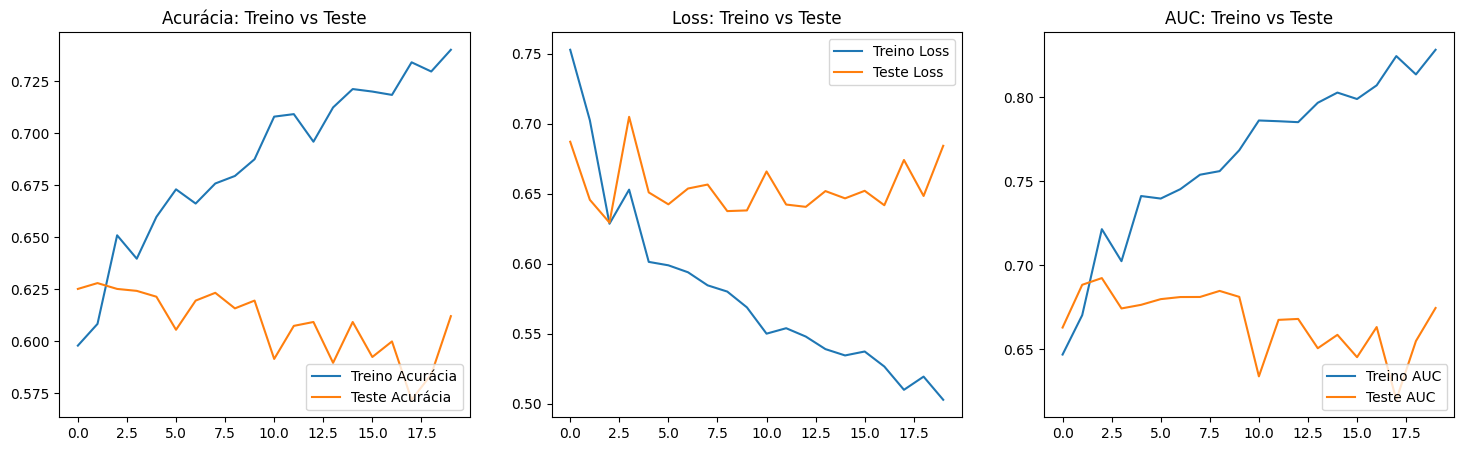

In [8]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy'] # Acurácia do Teste
    loss = history.history['loss']
    val_loss = history.history['val_loss']    # Loss do Teste
    auc = history.history['auc']
    val_auc = history.history['val_auc']      # AUC do Teste

    epochs_range = range(len(acc))

    plt.figure(figsize=(18, 5))

    # Gráfico de Acurácia
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, acc, label='Treino Acurácia')
    plt.plot(epochs_range, val_acc, label='Teste Acurácia')
    plt.legend(loc='lower right')
    plt.title('Acurácia: Treino vs Teste')

    # Gráfico de Loss
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, loss, label='Treino Loss')
    plt.plot(epochs_range, val_loss, label='Teste Loss')
    plt.legend(loc='upper right')
    plt.title('Loss: Treino vs Teste')

    # Gráfico de AUC
    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, auc, label='Treino AUC')
    plt.plot(epochs_range, val_auc, label='Teste AUC')
    plt.legend(loc='lower right')
    plt.title('AUC: Treino vs Teste')

    plt.show()

plot_history(history)

**Outro**

Benigno: BI-RADS 2 (benign), BI-RADS 3 (probably benign)

Maligno: BI-RADS 5 (highly suggestive of
malignancy) and BI-RADS 6 (known biopsy-proven).

https://vindr.ai/datasets/mammo

Duas Redes -> base x

Duas Redes -> base y

Classificador


Separar os dados pelo paciente para que a imagem do paciente X que está no treino não entre no Teste

https://www.medrxiv.org/content/10.1101/2022.03.07.22272009v1.full.pdf

https://www.physionet.org/content/vindr-mammo/1.0.0/


In [9]:
# --- 0. INSTALAÇÃO DE DEPENDÊNCIAS (Obrigatório rodar toda vez que iniciar a GPU) ---
import os

# Verifica se o pacote já está instalado para não instalar repetidamente sem necessidade
try:
    import kymatio
    print("Kymatio já está instalado.")
except ImportError:
    print("Instalando dependências (kymatio, natten, timm)...")
    !pip install kymatio natten timm -q
    print("Instalação concluída!")

# Agora tenta importar para garantir
import kymatio
import natten
import timm
print("Bibliotecas carregadas com sucesso.")

Instalando dependências (kymatio, natten, timm)...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 6.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 2.7 MB/s eta 0:00:00
Instalação concluída!
Bibliotecas carregadas com sucesso.


In [ ]:
# --- 5. CONFIGURAÇÃO DE TREINAMENTO (GPU) ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from kymatio.torch import Scattering2D
from PIL import Image
import numpy as np
import time
import copy
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score # <--- NOVO IMPORT

# Verifica se estamos na GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Hardware selecionado: {device}")

# --- 6. DATASET E DATALOADERS ---
class MammographyDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.label_map = {'Benign': 0, 'Malignant': 1}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = row['filepath']
        label_str = row['label']

        # Carrega imagem e força escala de cinza
        try:
            image = Image.open(img_path).convert('L')
        except:
            # Fallback para imagem preta se arquivo estiver corrompido
            image = Image.fromarray(np.zeros((224, 224), dtype=np.uint8), mode='L')

        # Converte label
        label = self.label_map[label_str]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

# Definição das transformações
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Divisão dos dados (usado o df_final)
if 'df_final' not in globals():
    raise NameError("df_final não definido. Rode o bloco de leitura dos dados primeiro.")

train_df, val_df = train_test_split(df_final, test_size=0.3, stratify=df_final['label'], random_state=42)

# Criação dos Loaders
train_dataset = MammographyDataset(train_df, transform=data_transforms)
val_dataset = MammographyDataset(val_df, transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)

# --- 7. ARQUITETURA DO MODELO (CORRIGIDA) ---
class ProposedModel(nn.Module):
    def __init__(self, device):
        super(ProposedModel, self).__init__()
        self.device = device

        # 1. Wavelet Scattering (81 canais)
        self.scattering = Scattering2D(J=2, shape=(224, 224), L=8).to(device)

        # 2. Backbone: Swin Transformer
        try:
            import timm
            # num_classes=0: Remove a camada final de classificação do Imagenet
            # global_pool='avg': Força o modelo a retornar um vetor pronto (Batch, 1024)
            self.backbone = timm.create_model(
                'swin_base_patch4_window7_224',
                pretrained=True,
                in_chans=81,
                num_classes=0,    # Retorna features brutas
                global_pool='avg' # Faz a média automaticamente da forma correta
            )
        except ImportError:
            raise ImportError("Instale a biblioteca timm: !pip install timm")

    def forward(self, x):
        # Scattering
        x = self.scattering(x)

        # Ajuste de dimensões se necessário (Batch, 81, 56, 56)
        if x.ndim == 5 and x.shape[1] == 1:
            x = x.squeeze(1)

        # Upsample para 224x224 (Swin espera isso)
        x = nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

        # Backbone (Agora chamamos direto, pois ele já tem o pooling configurado)
        features = self.backbone(x)

        return features

class FullSystem(nn.Module):
    def __init__(self, device):
        super(FullSystem, self).__init__()
        self.feature_extractor = ProposedModel(device)

        # Entrada 1024 (Swin Base) -> 512 -> 32 -> 1 (Saída)
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        feats = self.feature_extractor(x)
        return self.classifier(feats)

# --- 8. LOOP DE TREINAMENTO COM AUC ---

# Verifica GPU novamente
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Hardware em uso: {device}")
if device.type == 'cpu':
    print("Treino na CPU.")

# Instanciação
model = FullSystem(device).to(device)

# [cite_start]Função de Perda Focal [cite: 207]
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=1):
        super().__init__()
        self.gamma = gamma
        self.bce = nn.BCELoss(reduction='none')
    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        pt = torch.exp(-bce_loss)
        return torch.mean((1 - pt) ** self.gamma * bce_loss)

criterion = FocalLoss(gamma=1)
optimizer = optim.Adam(model.parameters(), lr=0.00001) # Learning rate do artigo [cite: 194]

print(f"\nIniciando treinamento com {len(train_dataset)} imagens...")
start_time = time.time()
best_acc = 0.0

# 20 Épocas
for epoch in range(20):
    # --- TREINO ---
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        # Move para o dispositivo (CPU ou GPU)
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1)

        optimizer.zero_grad()

        # Forward & Backward
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    # --- VALIDAÇÃO ---
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0

    # [cite_start]Listas para guardar histórico para cálculo da AUC [cite: 198]
    all_labels = []
    all_outputs = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)

            outputs = model(images)
            loss_val = criterion(outputs, labels)
            val_loss += loss_val.item() * images.size(0)

            # Threshold 0.5 para Acurácia
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Acumula para AUC (traz para CPU e converte para numpy)
            all_labels.extend(labels.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())

    epoch_loss_train = running_loss / len(train_dataset)
    epoch_loss_val = val_loss / len(val_dataset)
    epoch_acc = 100 * correct / total

    # [cite_start]Calcula AUC [cite: 199]
    try:
        epoch_auc = roc_auc_score(all_labels, all_outputs)
    except ValueError:
        # Pode ocorrer se o batch tiver apenas uma classe (muito raro com shuffle=True/stratify)
        epoch_auc = 0.5

    tempo_epoch = time.time() - start_time
    print(f"Época {epoch+1}/20 | Loss T: {epoch_loss_train:.4f} | Loss V: {epoch_loss_val:.4f} | Acc: {epoch_acc:.2f}% | AUC: {epoch_auc:.4f}")

    # Salva Melhor Modelo (Pode usar Acc ou AUC como critério)
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model.state_dict(), 'melhor_modelo_cancer.pth')
        print("   -> Modelo Salvo (Melhor Acurácia)")

print(f"\nTreino concluído! Melhor Acurácia Final: {best_acc:.2f}%")

Hardware selecionado: cpu
Hardware em uso: cpu
Treino na CPU.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]


Iniciando treinamento com 2497 imagens...
Época 1/20 | Loss T: 0.3271 | Loss V: 0.3106 | Acc: 64.71% | AUC: 0.6995
   -> Modelo Salvo (Melhor Acurácia)
Época 2/20 | Loss T: 0.2927 | Loss V: 0.2862 | Acc: 68.91% | AUC: 0.7540
   -> Modelo Salvo (Melhor Acurácia)
Época 3/20 | Loss T: 0.2669 | Loss V: 0.2751 | Acc: 70.77% | AUC: 0.7802
   -> Modelo Salvo (Melhor Acurácia)


Acrescentar
Resultados de Teste
Perda não precisa
Acurácia
AUC
O quão bem

Outra Base

https://www.kaggle.com/datasets/shantanughosh/vindr-mammogram-dataset-dicom-to-png/data

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shantanughosh/vindr-mammogram-dataset-dicom-to-png")

print("Path to dataset files:", path)

In [ ]:
import pandas as pd
import os
import kagglehub
from sklearn.model_selection import GroupShuffleSplit
import cv2
import matplotlib.pyplot as plt

# 1. Baixar/Carregar o dataset (O cache faz isso ser instantâneo se já baixou)
print("Verificando arquivos baixados...")
path_root = kagglehub.dataset_download("shantanughosh/vindr-mammogram-dataset-dicom-to-png")
print(f"Raiz do download: {path_root}")

# 2. LOCALIZADOR AUTOMÁTICO DE PASTA
# Vamos procurar onde está a pasta 'images_png' dentro do que foi baixado
img_base_path = None
for root, dirs, files in os.walk(path_root):
    if 'images_png' in dirs:
        img_base_path = os.path.join(root, 'images_png')
        print(f"Pasta de imagens encontrada em: {img_base_path}")
        break

if img_base_path is None:
    # Caso o nome seja diferente (ex: 'images'), tentamos usar a raiz
    print("Pasta 'images_png' não encontrada explicitamente. Tentando usar a raiz...")
    # Lista o que tem na raiz para ajudar no debug
    print(f"Conteúdo da raiz: {os.listdir(path_root)}")
    img_base_path = path_root # Tentativa de fallback

# 3. Carregar CSV (Upload Local)
CSV_PATH = "breast-level_annotations.csv"

if not os.path.exists(CSV_PATH):
    print(f"ERRO: O arquivo '{CSV_PATH}' não está no Colab.")
    print("Por favor, faça o upload do CSV novamente no menu lateral.")
else:
    df = pd.read_csv(CSV_PATH)

    # --- FILTRAGEM (CÓDIGO QUE JÁ FUNCIONOU) ---
    def definir_classe(valor):
        texto = str(valor).upper()
        apenas_numero = texto.replace('BI-RADS', '').strip()
        if apenas_numero in ['2', '3']: return 'Benign'
        elif apenas_numero in ['5', '6']: return 'Malignant'
        else: return None

    df['class_label'] = df['breast_birads'].apply(definir_classe)
    df_clean = df.dropna(subset=['class_label']).reset_index(drop=True)
    print(f"Total de amostras filtradas (Ben/Mal): {len(df_clean)}")

    # --- MONTAGEM DE CAMINHO E VERIFICAÇÃO ---
    print("Vinculando imagens ao CSV...")

    def montar_caminho(row):
        # O dataset VinDr tem a estrutura: images_png / study_id / image_id.png
        study = str(row['study_id'])
        img_id = str(row['image_id'])
        return os.path.join(img_base_path, study, img_id + '.png')

    df_clean['image_path'] = df_clean.apply(montar_caminho, axis=1)

    # Verificação Física das primeiras 5 imagens para ser rápido
    print("Testando as primeiras 5 imagens...")
    for i in range(5):
        path_teste = df_clean['image_path'].iloc[i]
        existe = os.path.exists(path_teste)
        status = "EXISTE" if existe else "NÃO ENCONTRADO"
        print(f"  [{i}] {status}: {path_teste}")

    # Filtrar apenas as existentes
    df_clean['exists'] = df_clean['image_path'].apply(os.path.exists)
    df_final = df_clean[df_clean['exists'] == True].copy()

    print("-" * 30)
    print(f"TOTAL FINAL DE IMAGENS PRONTAS: {len(df_final)}")

    if len(df_final) > 0:
        # --- DIVISÃO TREINO/TESTE ---
        splitter = GroupShuffleSplit(test_size=0.30, n_splits=1, random_state=42)
        groups = df_final['study_id']
        train_idx, test_idx = next(splitter.split(df_final, groups=groups))

        train_df = df_final.iloc[train_idx]
        test_df = df_final.iloc[test_idx]

        train_df.to_csv('train.csv', index=False)
        test_df.to_csv('test.csv', index=False)

        print("Arquivos 'train.csv' e 'test.csv' criados.")

        try:
            sample = train_df.iloc[0]
            img = cv2.imread(sample['image_path'])
            plt.imshow(img, cmap='gray')
            plt.title(f"Confirmação Visual: {sample['class_label']}")
            plt.axis('off')
            plt.show()
        except:
            print("Erro ao plotar imagem (mas os dados estão prontos).")

    else:
        print("Ainda encontrou 0 imagens.")
        if os.path.exists(img_base_path):
            print(f"Conteúdo de {img_base_path}:")
            print(os.listdir(img_base_path)[:10]) # Mostra os primeiros 10 itens

Parte 1: Função de Pré-processamento e Visualização

In [ ]:
import cv2
import numpy as np
import pywt
import matplotlib.pyplot as plt
from scipy.signal import wiener

# 1. Definir a Função de Pré-processamento do Artigo
def preprocess_image_paper_method(image_path):
    # Ler imagem em escala de cinza
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None, None, None

    # Redimensionar para 224x224 (Entrada padrão da CNN)
    img_resized = cv2.resize(img, (224, 224))

    # A. Filtro Wiener (Remoção de Ruído Adaptativa)
    # Janela 3x3 conforme solicitado
    img_wiener = wiener(img_resized, (3, 3))
    img_wiener = img_wiener.astype(np.uint8)

    # B. CLAHE (Realce de Contraste Local)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_clahe = clahe.apply(img_wiener)

    # C. Decomposição Wavelet (db3, nível 3)
    # Extrai características de frequência (suavidade e textura)
    coeffs = pywt.wavedec2(img_clahe, 'db3', level=3)
    cA3 = coeffs[0] # Coeficiente de aproximação (Low-Low frequency)

    # Redimensionar a Wavelet de volta para 224x224 para a CNN
    # (A wavelet reduz a imagem original para aprox 30x30, precisamos aumentar de volta)
    img_final = cv2.resize(cA3, (224, 224))

    # Normalizar para 0-255 uint8 para manipulação de imagem
    img_final_norm = cv2.normalize(img_final, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Converter para 3 canais (InceptionV3 exige RGB)
    img_final_rgb = cv2.cvtColor(img_final_norm, cv2.COLOR_GRAY2RGB)

    return img_resized, img_clahe, img_final_rgb

# --- VISUALIZAÇÃO DE TESTE ---
# Pega uma imagem real do seu DataFrame de treino
try:
    sample_path = train_df.iloc[0]['image_path']
    original, pos_clahe, final = preprocess_image_paper_method(sample_path)

    if original is not None:
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.title("1. Original (Redimensionada)")
        plt.imshow(original, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("2. Wiener + CLAHE")
        plt.imshow(pos_clahe, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("3. Final (Pós Wavelet db3)")
        plt.imshow(final)
        plt.axis('off')

        plt.show()
        print("Pré-processamento validado com sucesso!")
    else:
        print("Erro ao ler a imagem de teste.")
except Exception as e:
    print(f"Erro na visualização: {e}")

Parte 2: Preparação dos Labels e Generator Customizado

---



In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical

# 1. Converter as classes de Texto ('Benign'/'Malignant') para Números (0/1)
# Criamos a coluna 'target' necessária para o Generator
mapa_classes = {'Benign': 0, 'Malignant': 1}

train_df['target'] = train_df['class_label'].map(mapa_classes)
test_df['target'] = test_df['class_label'].map(mapa_classes)

print("Distribuição Numérica Treino:", train_df['target'].value_counts().to_dict())
print("Distribuição Numérica Teste:", test_df['target'].value_counts().to_dict())

# 2. Definir o Gerador de Dados (Data Generator)
class CustomDataGenerator(Sequence):
    def __init__(self, dataframe, x_col, y_col, batch_size=16, shuffle=True):
        self.dataframe = dataframe
        self.x_col = x_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.dataframe))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        # Retorna o número de lotes por época
        return int(np.floor(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        # Seleciona os índices do lote atual
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_df = self.dataframe.iloc[indexes]

        # Inicializa arrays vazios para o lote
        X = np.empty((self.batch_size, 224, 224, 3))
        y = np.empty((self.batch_size, 2), dtype=float)

        for i, (_, row) in enumerate(batch_df.iterrows()):
            img_path = row[self.x_col]
            label = row[self.y_col]

            # --- PROCESSAMENTO DO ARTIGO ---
            try:
                # Chama a função definida na Parte 1 e pega o índice [2] (imagem final RGB)
                _, _, img_final_rgb = preprocess_image_paper_method(img_path)

                if img_final_rgb is None:
                    # Fallback seguro (imagem preta) caso o arquivo esteja corrompido
                    X[i,] = np.zeros((224, 224, 3))
                else:
                    # Normalização Fundamental para Redes Neurais (0.0 a 1.0)
                    X[i,] = img_final_rgb / 255.0

            except Exception as e:
                print(f"Erro em {img_path}: {e}")
                X[i,] = np.zeros((224, 224, 3))

            # One-Hot Encoding Manual
            # [1, 0] = Benigno (Classe 0)
            # [0, 1] = Maligno (Classe 1)
            if label == 0:
                y[i,] = [1, 0]
            else:
                y[i,] = [0, 1]

        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# 3. Instanciar os Geradores
batch_size = 16

train_gen = CustomDataGenerator(
    train_df,
    x_col='image_path',
    y_col='target',
    batch_size=batch_size,
    shuffle=True
)

val_gen = CustomDataGenerator(
    test_df,
    x_col='image_path',
    y_col='target',
    batch_size=batch_size,
    shuffle=False
)

print("Geradores criados.")

Parte 3: Construção e Treinamento da GoogleNet (InceptionV3)

Arquitetura (Adam, lr=0.0001, 20 épocas)

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# 1. Carrega Base GoogleNet (InceptionV3)
# include_top=False remove a camada final de 1000 classes (ImageNet)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# congelando por estabilidade.
for layer in base_model.layers:
    layer.trainable = False

# 2. Adicionar o Topo (Classificação Binária)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)                   # Evita Overfitting (50% dropout)
x = Dense(1024, activation='relu')(x) # Camada densa robusta
predictions = Dense(2, activation='softmax')(x) # 2 Neurônios (Benigno/Maligno)

model = Model(inputs=base_model.input, outputs=predictions)

# 3. Taxa de aprendizado 0.0001 e otimizador Adam
opt = Adam(learning_rate=0.0001)

model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# 4. Treino
print(f"--- Iniciando Treino (20 Épocas) ---")
print(f"Imagens de Treino: {len(train_df)}")
print(f"Imagens de Teste: {len(test_df)}")

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    verbose=1
)

# 5. Salva
model.save('modelo_googlenet_mammo_final.h5')
print("Modelo salvo como 'modelo_googlenet_mammo_final.h5'")

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
--- Iniciando Treino (20 Épocas) ---
Imagens de Treino: 4072
Imagens de Teste: 1760


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.12/dist-packages/scipy/signal/_signaltools.py:1783: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
/usr/local/lib/python3.12/dist-packages/scipy/signal/_signaltools.py:1783: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)
/tmp/ipython-input-2934319081.py:20: RuntimeWarning: invalid value encountered in cast
  img_wiener = img_wiener.astype(np.uint8)


Epoch 1/20
254/254 ━━━━━━━━━━━━━━━━━━━━ 548s 2s/step - accuracy: 0.9383 - auc: 0.9533 - loss: 0.2754 - val_accuracy: 0.9545 - val_auc: 0.9779 - val_loss: 0.1639
Epoch 2/20
254/254 ━━━━━━━━━━━━━━━━━━━━ 541s 2s/step - accuracy: 0.9667 - auc: 0.9844 - loss: 0.1309 - val_accuracy: 0.9568 - val_auc: 0.9781 - val_loss: 0.1599
Epoch 3/20
254/254 ━━━━━━━━━━━━━━━━━━━━ 578s 2s/step - accuracy: 0.9593 - auc: 0.9849 - loss: 0.1376 - val_accuracy: 0.9443 - val_auc: 0.9739 - val_loss: 0.2080
Epoch 4/20
254/254 ━━━━━━━━━━━━━━━━━━━━ 520s 2s/step - accuracy: 0.9569 - auc: 0.9831 - loss: 0.1433 - val_accuracy: 0.9557 - val_auc: 0.9802 - val_loss: 0.1758
Epoch 5/20
254/254 ━━━━━━━━━━━━━━━━━━━━ 543s 2s/step - accuracy: 0.9624 - auc: 0.9844 - loss: 0.1408 - val_accuracy: 0.9602 - val_auc: 0.9786 - val_loss: 0.1597
Epoch 6/20
254/254 ━━━━━━━━━━━━━━━━━━━━ 531s 2s/step - accuracy: 0.9610 - auc: 0.9861 - loss: 0.1322 - val_accuracy: 0.9574 - val_auc: 0.9795 - val_loss: 0.1580
Epoch 7/20
254/254 ━━━━━━━━━━━━━━━

Modelo salvo como 'modelo_googlenet_mammo_final.h5'


AUC (Area Under Curve): ~0.98 (0.9782)

Os conjuntos de Teste (acrescentar)

In [ ]:
Segunda Segunda